In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

Load dataset

In [2]:
data_df = pd.read_csv("https://raw.githubusercontent.com/joshuanallen/Air_Quality_Prediction/main/datasets/clean_data.csv")
data_df.head()

,Unnamed: 0,Census Tract,Total Population,ZIP,Longitude,Latitude,Ozone,PM2.5,Diesel PM,Pesticides,Tox. Release,Traffic,Asthma,Low Birth Weight,Cardiovascular Disease,Poverty,Unemployment
0,0,6019001100,3174,93706,-119.781696,36.709695,0.065,15.40,48.524,2.75,18551.957190,909.14,131.64,7.44,14.13,76.3,17.6
1,1,6071001600,6133,91761,-117.618013,34.057780,0.062,13.31,38.556,1.37,7494.236622,782.26,60.66,7.04,12.94,72.5,12.3
2,2,6019000200,3167,93706,-119.805504,36.735491,0.062,15.40,47.445,3.03,12454.948410,576.52,142.12,10.16,14.96,86.8,16.1
3,3,6077000801,6692,95203,-121.314524,37.940517,0.046,12.54,24.117,12.93,2387.782922,1305.01,142.17,6.23,14.72,61.3,19.6
4,4,6019001500,2206,93725,-119.717843,36.681600,0.065,15.40,18.846,3518.41,21790.706720,435.16,90.48,4.50,12.82,66.4,18.6


Drop unecessary columns

In [3]:
drop_loc_data_df = data_df[["Ozone", "PM2.5", "Diesel PM", "Pesticides", "Tox. Release", "Traffic", "Asthma", "Low Birth Weight", "Cardiovascular Disease", "Poverty", "Unemployment"]]
drop_loc_data_df.head()

,Ozone,PM2.5,Diesel PM,Pesticides,Tox. Release,Traffic,Asthma,Low Birth Weight,Cardiovascular Disease,Poverty,Unemployment
0,0.065,15.40,48.524,2.75,18551.957190,909.14,131.64,7.44,14.13,76.3,17.6
1,0.062,13.31,38.556,1.37,7494.236622,782.26,60.66,7.04,12.94,72.5,12.3
2,0.062,15.40,47.445,3.03,12454.948410,576.52,142.12,10.16,14.96,86.8,16.1
3,0.046,12.54,24.117,12.93,2387.782922,1305.01,142.17,6.23,14.72,61.3,19.6
4,0.065,15.40,18.846,3518.41,21790.706720,435.16,90.48,4.50,12.82,66.4,18.6


Check for missing data

In [4]:
print(drop_loc_data_df.isnull().sum())

Ozone                     0
PM2.5                     0
Diesel PM                 0
Pesticides                0
Tox. Release              0
Traffic                   0
Asthma                    0
Low Birth Weight          0
Cardiovascular Disease    0
Poverty                   0
Unemployment              0
dtype: int64


Summarize dataset to help with binning

In [5]:
drop_loc_data_df.describe()

,Ozone,PM2.5,Diesel PM,Pesticides,Tox. Release,Traffic,Asthma,Low Birth Weight,Cardiovascular Disease,Poverty,Unemployment
count,7712.000000,7712.000000,7712.000000,7712.000000,7712.000000,7712.000000,7712.000000,7712.000000,7712.000000,7712.000000,7712.000000
mean,0.047426,10.420606,19.348765,320.518047,3204.873215,953.325455,52.503613,4.980663,8.320344,36.412202,10.182923
std,0.010220,2.568878,16.469596,2822.298975,12652.368968,913.593370,30.330867,1.550364,2.929641,20.251424,4.957414
min,0.026000,1.869001,0.021000,0.000000,0.000000,22.410000,3.630000,0.000000,1.560000,1.000000,0.000000
25%,0.040000,8.697944,9.172000,0.000000,103.800931,450.047500,30.420000,3.960000,6.140000,19.200000,6.600000
50%,0.046000,10.370000,16.725500,0.000000,489.912078,706.890000,45.900000,4.920000,8.005000,33.600000,9.300000
75%,0.055000,12.050000,24.740750,0.360000,3571.025854,1207.335000,66.430000,5.930000,10.080000,51.600000,12.800000
max,0.068000,19.600000,208.400000,91316.190000,842751.329300,45687.870000,223.300000,14.890000,21.260000,94.900000,60.500000


Bin continuous variables for classification

In [6]:
# Asthma Binning
asthma_bins = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225]

asthma_labels =[1,2,3,4,5,6,7,8,9]

drop_loc_data_df['Asthma_binned'] = pd.cut(drop_loc_data_df["Asthma"], bins = asthma_bins, labels = asthma_labels, include_lowest=True)


# Low birth weight binning
lbw_bins = [0, 3, 6, 9, 12, 15]

lbw_labels =[1,2,3,4,5]

drop_loc_data_df['LBW_binned'] = pd.cut(drop_loc_data_df["Low Birth Weight"], bins = lbw_bins, labels = lbw_labels, include_lowest=True)


# Cardiovascular Disease Binning
cvd_bins = [0, 3, 6, 9, 12, 14, 16, 18, 20, 22]

cvd_labels =[1,2,3,4,5,6,7,8,9]

drop_loc_data_df['CVD_binned'] = pd.cut(drop_loc_data_df["Cardiovascular Disease"], bins = cvd_bins, labels = cvd_labels, include_lowest=True)


# Poverty
poverty_bins = [0, 20, 40, 60, 80, 100]

poverty_labels =[1,2,3,4,5]

drop_loc_data_df['Poverty_binned'] = pd.cut(drop_loc_data_df["Poverty"], bins = poverty_bins, labels = poverty_labels, include_lowest=True)


# Unemployment
ue_bins = [0, 5, 10, 15, 20, 25, 100]

ue_labels =[1,2,3,4,5,6]

drop_loc_data_df['Unemployment_binned'] = pd.cut(drop_loc_data_df["Unemployment"], bins = ue_bins, labels = ue_labels, include_lowest=True)


drop_loc_data_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

,Ozone,PM2.5,Diesel PM,Pesticides,Tox. Release,Traffic,Asthma,Low Birth Weight,Cardiovascular Disease,Poverty,Unemployment,Asthma_binned,LBW_binned,CVD_binned,Poverty_binned,Unemployment_binned
0,0.065,15.40,48.524,2.75,18551.957190,909.14,131.64,7.44,14.13,76.3,17.6,6,3,6,4,4
1,0.062,13.31,38.556,1.37,7494.236622,782.26,60.66,7.04,12.94,72.5,12.3,3,3,5,4,3
2,0.062,15.40,47.445,3.03,12454.948410,576.52,142.12,10.16,14.96,86.8,16.1,6,4,6,5,4
3,0.046,12.54,24.117,12.93,2387.782922,1305.01,142.17,6.23,14.72,61.3,19.6,6,3,6,4,4
4,0.065,15.40,18.846,3518.41,21790.706720,435.16,90.48,4.50,12.82,66.4,18.6,4,2,5,4,4


Set feature and target variables

In [7]:
# Features
X_air_data = drop_loc_data_df[["Ozone", "PM2.5", "Diesel PM", "Pesticides", "Tox. Release", "Traffic"]]

# targets
y_Asthma_binned = drop_loc_data_df["Asthma_binned"]
y_Low_birth_weight_binned = drop_loc_data_df["LBW_binned"]
y_Cardiovascular_disease_binned = drop_loc_data_df["CVD_binned"]
y_Poverty_binned = drop_loc_data_df["Poverty_binned"]
y_Unemployment_binned = drop_loc_data_df["Unemployment_binned"]

Standarize numerical variables

1. Split into training and testing datasets
2. Scale the feature data
3. Train and evaluate the Random Forest Classifier

**Asthma** Random Forest Classification Model

In [8]:
X = X_air_data
y = y_Asthma_binned

# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

# Create a StandardScaler instance
scaler = StandardScaler()
# scaler = MinMaxScaler()
# scaler = RobustScaler()


# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=128, random_state=78)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)
print(f"Random forest predictive accuracy: {accuracy_score(y_test,y_pred):.3f}")

# Print Classification Report
print("Classification Report")
print(classification_report(y_test, y_pred))

# Visualise classical Confusion Matrix
CM = confusion_matrix(y_test, y_pred, labels=asthma_labels)

cm_df = pd.DataFrame(CM, 
                     index = ["Actual 1", "Actual 2", "Actual 3",  "Actual 4", "Actual 5", "Actual 6", "Actual 7", "Actual 8", "Actual 9"],
                     columns= ["Predicted 1", "Predicted 2", "Predicted 3", "Predicted 4", "Predicted 5", "Predicted 6", "Predicted 7", "Predicted 8", "Predicted 9"])
cm_df

Random forest predictive accuracy: 0.612
Classification Report
              precision    recall  f1-score   support

           1       0.72      0.58      0.64       292
           2       0.64      0.76      0.70       765
           3       0.57      0.54      0.55       517
           4       0.50      0.49      0.49       212
           5       0.49      0.38      0.43        77
           6       0.55      0.29      0.38        38
           7       0.40      0.33      0.36        18
           8       1.00      0.29      0.44         7
           9       0.00      0.00      0.00         2

    accuracy                           0.61      1928
   macro avg       0.54      0.41      0.44      1928
weighted avg       0.61      0.61      0.61      1928



,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7,Predicted 8,Predicted 9
Actual 1,170,103,15,3,1,0,0,0,0
Actual 2,51,579,115,16,2,0,2,0,0
Actual 3,7,171,279,51,6,1,2,0,0
Actual 4,6,28,60,103,13,2,0,0,0
Actual 5,2,9,12,21,29,3,1,0,0
Actual 6,0,6,7,5,7,11,1,0,1
Actual 7,0,2,1,5,1,3,6,0,0
Actual 8,0,0,1,2,0,0,2,2,0
Actual 9,0,0,0,1,0,0,1,0,0


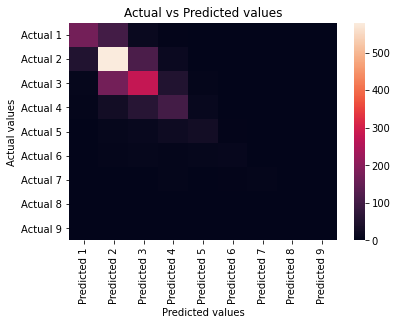

In [9]:
# Visualize it as a heatmap
import seaborn
seaborn.heatmap(cm_df)

plt.title("Actual vs Predicted values")
plt.xlabel("Predicted values")
plt.ylabel("Actual values")
plt.show()

**Low Birth Weight** Random Forest Classifier model

In [10]:
X = X_air_data
y = y_Low_birth_weight_binned

# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

# Create a StandardScaler instance
scaler = StandardScaler()
# scaler = MinMaxScaler()
# scaler = RobustScaler()


# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=128, random_state=78)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)
print(f"Random forest predictive accuracy: {accuracy_score(y_test,y_pred):.3f}")

# Print Classification Report
print("Classification Report")
print(classification_report(y_test, y_pred))

# Visualise classical Confusion Matrix
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(y_test, y_pred, labels=lbw_labels)

cm_df = pd.DataFrame(CM, 
                     index = ["Actual 1", "Actual 2", "Actual 3",  "Actual 4", "Actual 5"],
                     columns= ["Predicted 1", "Predicted 2", "Predicted 3", "Predicted 4", "Predicted 5"])
cm_df

Random forest predictive accuracy: 0.666
Classification Report
              precision    recall  f1-score   support

           1       0.13      0.03      0.04       151
           2       0.71      0.90      0.79      1315
           3       0.43      0.22      0.30       441
           4       0.20      0.05      0.08        20
           5       0.00      0.00      0.00         1

    accuracy                           0.67      1928
   macro avg       0.30      0.24      0.24      1928
weighted avg       0.60      0.67      0.61      1928



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5
Actual 1,4,136,11,0,0
Actual 2,21,1181,110,3,0
Actual 3,5,336,99,1,0
Actual 4,0,11,8,1,0
Actual 5,0,1,0,0,0


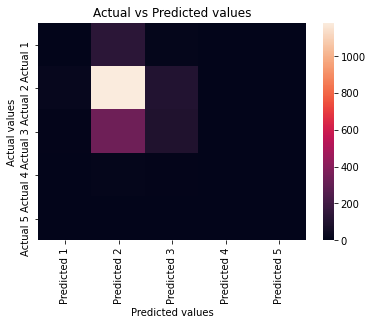

In [11]:
# Visualize it as a heatmap
import seaborn
seaborn.heatmap(cm_df)

plt.title("Actual vs Predicted values")
plt.xlabel("Predicted values")
plt.ylabel("Actual values")
plt.show()

**Cardiovascular disease** Random Forest Classifier model

In [12]:
X = X_air_data
y = y_Cardiovascular_disease_binned

# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

# Create a StandardScaler instance
scaler = StandardScaler()
# scaler = MinMaxScaler()
# scaler = RobustScaler()


# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=128, random_state=78)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)
print(f"Random forest predictive accuracy: {accuracy_score(y_test,y_pred):.3f}")

# Print Classification Report
print("Classification Report")
print(classification_report(y_test, y_pred))

# Visualise classical Confusion Matrix
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(y_test, y_pred, labels=cvd_labels)

cm_df = pd.DataFrame(CM, 
                     index = ["Actual 1", "Actual 2", "Actual 3",  "Actual 4", "Actual 5", "Actual 6", "Actual 7", "Actual 8", "Actual 9"],
                     columns= ["Predicted 1", "Predicted 2", "Predicted 3", "Predicted 4", "Predicted 5", "Predicted 6", "Predicted 7", "Predicted 8", "Predicted 9"])
cm_df

Random forest predictive accuracy: 0.599
Classification Report
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        11
           2       0.70      0.60      0.65       439
           3       0.58      0.70      0.63       740
           4       0.60      0.57      0.58       516
           5       0.51      0.38      0.43       151
           6       0.41      0.31      0.35        48
           7       1.00      0.20      0.33        15
           8       0.00      0.00      0.00         3
           9       1.00      0.20      0.33         5

    accuracy                           0.60      1928
   macro avg       0.53      0.33      0.37      1928
weighted avg       0.60      0.60      0.59      1928



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7,Predicted 8,Predicted 9
Actual 1,0,10,1,0,0,0,0,0,0
Actual 2,1,265,155,16,1,1,0,0,0
Actual 3,0,96,521,110,9,4,0,0,0
Actual 4,0,6,182,293,29,6,0,0,0
Actual 5,0,2,33,51,57,8,0,0,0
Actual 6,0,1,6,15,11,15,0,0,0
Actual 7,0,0,3,3,4,2,3,0,0
Actual 8,0,0,2,1,0,0,0,0,0
Actual 9,0,0,2,0,1,1,0,0,1


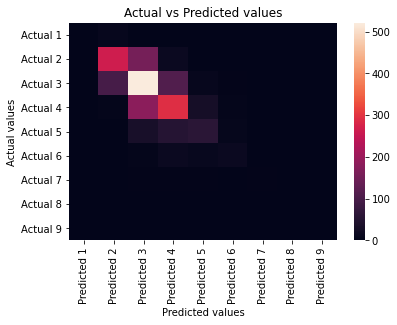

In [13]:
# Visualize it as a heatmap
import seaborn
seaborn.heatmap(cm_df)

plt.title("Actual vs Predicted values")
plt.xlabel("Predicted values")
plt.ylabel("Actual values")
plt.show()

**Poverty** Random Forest Classifier model


In [14]:
X = X_air_data
y = y_Poverty_binned

# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

# Create a StandardScaler instance
scaler = StandardScaler()
# scaler = MinMaxScaler()
# scaler = RobustScaler()


# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=128, random_state=78)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)
print(f"Random forest predictive accuracy: {accuracy_score(y_test,y_pred):.3f}")

# Print Classification Report
print("Classification Report")
print(classification_report(y_test, y_pred))

# Visualise classical Confusion Matrix
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(y_test, y_pred, labels=poverty_labels)

cm_df = pd.DataFrame(CM, 
                     index = ["Actual 1", "Actual 2", "Actual 3",  "Actual 4", "Actual 5"],
                     columns= ["Predicted 1", "Predicted 2", "Predicted 3", "Predicted 4", "Predicted 5"])
cm_df

Random forest predictive accuracy: 0.493
Classification Report
              precision    recall  f1-score   support

           1       0.62      0.63      0.62       492
           2       0.47      0.51      0.49       644
           3       0.44      0.39      0.41       513
           4       0.44      0.42      0.43       259
           5       0.12      0.15      0.13        20

    accuracy                           0.49      1928
   macro avg       0.42      0.42      0.42      1928
weighted avg       0.49      0.49      0.49      1928



,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5
Actual 1,311,146,28,6,1
Actual 2,149,329,126,38,2
Actual 3,38,183,199,90,3
Actual 4,7,40,87,109,16
Actual 5,0,2,9,6,3


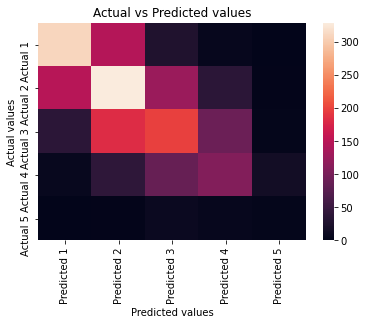

In [15]:
# Visualize it as a heatmap
import seaborn
seaborn.heatmap(cm_df)

plt.title("Actual vs Predicted values")
plt.xlabel("Predicted values")
plt.ylabel("Actual values")
plt.show()

**Unemployment** Random Forest Classifier model

In [16]:
X = X_air_data
y = y_Unemployment_binned

# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

# Create a StandardScaler instance
scaler = StandardScaler()
# scaler = MinMaxScaler()
# scaler = RobustScaler()


# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=128, random_state=78)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)
print(f"Random forest predictive accuracy: {accuracy_score(y_test,y_pred):.3f}")

# Print Classification Report
print("Classification Report")
print(classification_report(y_test, y_pred))

# Visualise classical Confusion Matrix
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(y_test, y_pred, labels=ue_labels)

cm_df = pd.DataFrame(CM, 
                     index = ["Actual 1", "Actual 2", "Actual 3",  "Actual 4", "Actual 5", "Actual 6"],
                     columns= ["Predicted 1", "Predicted 2", "Predicted 3", "Predicted 4", "Predicted 5", "Predicted 6"])
cm_df

Random forest predictive accuracy: 0.442
Classification Report
              precision    recall  f1-score   support

           1       0.28      0.14      0.19       230
           2       0.53      0.65      0.59       867
           3       0.36      0.37      0.36       530
           4       0.32      0.23      0.27       226
           5       0.20      0.12      0.15        59
           6       0.00      0.00      0.00        16

    accuracy                           0.44      1928
   macro avg       0.28      0.25      0.26      1928
weighted avg       0.42      0.44      0.42      1928



,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6
Actual 1,33,165,29,2,0,1
Actual 2,70,566,196,31,4,0
Actual 3,14,252,195,58,8,3
Actual 4,1,63,95,52,14,1
Actual 5,0,12,26,13,7,1
Actual 6,0,5,4,5,2,0


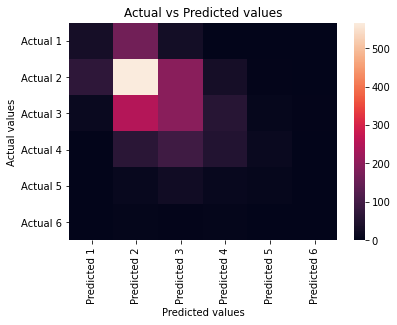

In [17]:
# Visualize it as a heatmap
import seaborn
seaborn.heatmap(cm_df)

plt.title("Actual vs Predicted values")
plt.xlabel("Predicted values")
plt.ylabel("Actual values")
plt.show()